Let's create `macrograd` from scratch following Andrej Karpathy's guide

In [73]:
# This is all we need to create macrograd
# Amazing, isn't it?
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
# Using `graphviz` to visualize the computation graph
from graphviz import Digraph


def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [75]:
class Value:
    
    def __init__(self, data, _op=None, _children=(), label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._op = _op
        self._prev = set(_children)
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _op='+', _children={self, other})
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _op='*', _children={self, other})
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        out = Value(math.tanh(self.data), _op='tanh', _children=(self,))
        
        def _backward():
            self.grad += (1 - out.data ** 2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        # this is topological sorting (in Graph theory)
        # not topological order (in Physics - Quantum Mechanics)
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for v in reversed(topo):
            v._backward()
    
    def zero_grad(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for v in topo:
            v.grad = 0.0


In [76]:
# build a expression

a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label="f")
L = d * f; L.label = 'L'

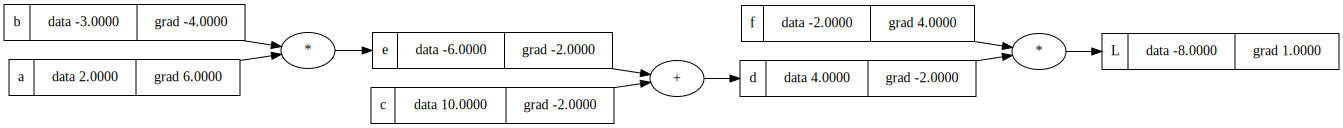

In [79]:
draw_dot(L)

In [78]:
L.zero_grad()
L.backward()